### Mixed foraging and compartment model

broadly
- do equids as trial
    - range of equid body masses, optimal foraging strat

To do
- fix graphs of body condition by scenario
- find out why data ends so early (done)
    - reason - total length of entries is the max possible size. Long travel distances
      and small velocities will mean only a small number of entries

Current Dynamic
- chewing occurs without mouth filling
- stomach fills, fat depletes
    - processing limited
    - basically a comparison of mean metabolic rate and gamma

Problems


Notes
- could restructure chewing so it's a single event done till mouth empty


#### outlfow rate thoughts
- kramer 2010 sets a level of gut content at which foraging stops and resumes
- possible components


##### Current State of Variables
1) foraging strategies - Justin's 
2) alpha               - allometric
3) beta                - allometric
4) gamma               - allometric
5) resource gain       - 16.7 kj/g as in pure carb/protein
6) mouth size          - allometric
7) gut size            - allometric, gut type
8) fat max             - allometric
9) velocity            - allometric
10) metabolic rates    - allometric

In [1]:
using Distributed

#addprocs(3);

In [2]:
@everywhere using RCall
@everywhere using JLD2
@everywhere using SharedArrays
@everywhere using Distributions
@everywhere using LinearAlgebra


@everywhere include("/home/taran/Documents/science/code/thesis_code/foraging_model/trait_and_rate_functions.jl") # functions for the resource landscape
@everywhere include("/home/taran/Documents/science/code/thesis_code/foraging_model/space_and_time_functions.jl") # functions for the consumer dynamics

#@everywhere include("/home/taran/Documents/science/code/thesis_code/foraging_model/intake_model_functions.jl") # functions for the resource landscape

    

In [3]:
using Random
#Random.seed!(42);

In [4]:
number_resources = 2;
target_values = [0.0, 0.25, 0.5, 0.75, 1.0]; 
strategy_id = repeat(collect(1:number_resources), inner=(length(target_values), 1));
target_weight = repeat(target_values, outer=(number_resources, 1));
strategy_info = Tuple([strategy_id, target_weight]);
number_strategies = length(strategy_id);

bern_array = generate_bern_array(target_weight);

In [5]:
configurations = 3

t = 0;   #[s]
# it will run for a week if not parallel, will not if parallel
# runs up to 200000s on +1 proc, crashes on more
# will crash kernel on a week of non-parallel unless shit dies early
t_max = 50000; # 2629800s in a month, 604800 in a week

# first pass RLB plant data suggested 0.1-0.3 kgC/m2yr
# experiment with monthly productivity as mean 8.3-25 g/m2month
#resource_gain = [16.7, 16.7];



In [6]:
# grass, browse
# hummel 2008 metabolizable energy
# [grass, dicot browse] 
resource_gain = [10.0, 10.0]#[7.5 ,11.3]; # kj/g
#crude_protein = [15.3, 20.7] # % dry matter
#ndf = [62.8, 43.2,] # % drymatter

# 20.0 t/hc Carbon biomass in tropical grassland/shrubland (2.7annual npp)
# from Tanentzap and Coomes "Carbon storage in terrestrial ecosystems: do
#browsing and grazing herbivores matter?"
# I'm going to assume the available biomass stays fixed and only ratios change between
# scenarios. Later need to account for g C -> dry mass conversion
# conversion of t/hc -> g/m2 is *100
# each scenario has 2000g/m2
resource_scenarios = [#grass, browse
                     [[1.0 1900.0];  [1.5 1901.0]], # forest
                     [[500.0 1500.0];  [501.0 1501.0]], # shrubland
                     [[1000.0 1000.0]; [1001.0 10010.0]], # 50:50
                     [[1500.0 500.0];  [1501.0 501.0]], # savana 
                     [[1900.0 1.0];  [1901.0 1.5]] # grassland
                     
    ];

number_scenarios = length(resource_scenarios);
scenario_list = 1:number_scenarios;

In [7]:
#generate_gamma_array(resource_scenarios)

In [8]:
# need array with input species parameters
# mass [kg], teeth, gut
species_list = [
    1.0  "lophs and non-flat" "colon"
    10.0  "lophs and non-flat" "colon"
    100.0  "lophs and non-flat" "colon"
    1000.0  "lophs and non-flat" "colon"
    10000.0  "lophs and non-flat" "colon"
];

number_species = length(species_list[:,1]);



In [9]:
bern_array[10]

Bernoulli{Float64}(p=0.0)

In [10]:
# collect config_data for testing
#body_con_data =Array{Union{Missing, Float64}}(missing, t_max, 6, number_scenarios,  
#    length(strategy_id), number_species, configurations);

body_con_data = SharedArray{Float64}(100000, 8, number_scenarios,  
    length(strategy_id), number_species, configurations);

gamma_array = generate_gamma_array(resource_scenarios); # gamma distributions
trait_array = generate_trait_array(species_list); # array of species traits
rate_array = generate_rate_array(species_list); # alpha and beta rates

loop_array = generate_loop_array(number_species, number_scenarios, number_strategies,
        configurations);

# at sync makes the processors wait for other processors
#@time @sync @distributed
@time for index in 1:length(loop_array[:,1])
    
    species = loop_array[index, 1]
    scenario = loop_array[index, 2]
    target = loop_array[index, 3]
    config = loop_array[index, 4]
    
    alpha = [rate_array[species][1], rate_array[species][2]]
    beta = rate_array[species][3]

    # mouth size, gut size, mrt, mps, velocity, 
    # initial_energy_state, basal, field, fat_max
    
    
    mouth_max = trait_array[species][1]
    gut_fill_max = trait_array[species][2]
    mrt = trait_array[species][3]
    mps = trait_array[species][4]
    velocity = trait_array[species][5]
    initial_energy_state = trait_array[species][6]
    basal = trait_array[species][7]
    field = trait_array[species][8]
    costs = [basal, field];
    fat_max = trait_array[species][9]
    
    
    

    resource_stats = resource_scenarios[scenario];
    bernoulli_dist = bern_array[target]
    gamma_dist = gamma_array[scenario]

#target=1;
t=0;
num_succ = [0,0];

at_food = false;
cropping = false;
chewing = false;

mouth = [0.0, 0.0];  #[g]
gut = [gut_fill_max/2, gut_fill_max/2]  ;  #[g]
fat = initial_energy_state;   #[g]
        
chosen_resource = 0;
ind = 0
###
#1 while there is time left in the day
    
while t <= t_max && fat >= 0.0

    gamma = outflow_rate(gut, gut_fill_max, mrt, mps)
    #rates = [alpha, beta, gamma]
    ### ###
    #2 if you're hungry
    #if gut <= gut_fill_max && fat <= fat_max  
        
        # if you're not at some food
        if at_food == false;
            # selects a resource to go after
            #chosen_resource, distance = forage(strategy_id, target_weight, target, 
                #resource_stats);
            #travel_time = distance/velocity; 
            chosen_resource, travel_time = travel(strategy_id, target_weight, 
                            target, resource_stats, velocity, t, t_max, 
                            bernoulli_dist, gamma_dist)            
                        
            # move to the food
            mouth, gut, fat = update_compartments2(travel_time, mouth, gut,
                fat, [alpha, beta, gamma], costs, resource_gain; travelling=true)
            t += travel_time;
            at_food = true;
                    
                if fat <= 0
                    break
                end
                    
        end
        
        ### ### ###
        #3 if mouth isn't full and you're not chewing and you're at some food
        if sum(mouth) < mouth_max &&  chewing == false && at_food == true  # crop some food
            handling_time = 1/alpha[chosen_resource]        
            
            mouth, gut, fat = update_compartments2((1/handling_time), 
                mouth, gut, fat, [alpha, beta, gamma], costs, resource_gain; cropping=true, resource=chosen_resource)
            
            num_succ[chosen_resource] += 1
            
            t += handling_time
            at_food = false;
                    
                    if fat <= 0
                    break
                end
                    
        end
        
        # if you're mouth is full but not chewing
        if sum(mouth) >= mouth_max && chewing == false 
                    
                # if mouth contents went slightly over max, returns then to max
                mouth = [pool_prop(mouth, 1)*mouth_max, pool_prop(mouth, 2)*mouth_max];
                chewing = true # start chewing
        end
        
        
        if chewing == true && sum(mouth) > beta # if you are currently chewing   
            mouth, gut, fat = update_compartments2((1/beta), mouth, 
                gut, fat, [alpha, beta, gamma], costs, resource_gain; chewing=true)
            t += (1/beta);
                    
                if fat <= 0.0
                    break
                end
                    
        end
        if chewing == true && sum(mouth) <= beta
                chewing = false
            
            end #3 end of if mouth isn't full and you're not chewing
        ### ### ###
                        
        #end #2 end of if you're not hungry
        ### ###    
        
                    
        # add note on why this was necessary
        mouth, gut, fat = update_compartments2(1, mouth, 
                gut, fat, [alpha, beta, gamma], costs, resource_gain)
        
        #if fat <= 0
         #           break
          #      end
                
        t += 1.0;
        
 
#(t_max, 6, number_scenarios,  number_strategies, number_species, configurations)        
        #100000×6×7×10×5×3
        #data_vec = [t, num_succ[1], num_succ[2], mouth, gut, fat]
        if t >= (t_max - 99999)
            ind += 1;
            body_con_data[ind, 1, scenario, target, species, config] = t;
            body_con_data[ind, 2,scenario, target, species, config] = num_succ[1];
            body_con_data[ind, 3,scenario, target, species, config] = num_succ[2];
            body_con_data[ind, 4,scenario, target, species, config] = mouth[1];
            body_con_data[ind, 5,scenario, target, species, config] = mouth[2];
            body_con_data[ind, 6,scenario, target, species, config] = gut[1];
            body_con_data[ind, 7,scenario, target, species, config] = gut[2];
            body_con_data[ind, 8,scenario, target, species, config] = fat;
        end
        
    end  #1 end bout (while t<tmax_bout )
    ###

#time, data, scenarios, strats, species, configurations
    

    end #loop 


# time, graze, browse, mouth, gut, fat

557.312103 seconds (3.71 G allocations: 93.638 GiB, 1.98% gc time)


#### Code for generating the matrix graph of optimal strategies

In [11]:
#What is all of this

# emptry array for holding scenario, strats, and species for plotting
plot_array=zeros(Float64, number_scenarios, number_strategies, number_species);

# for each scene/strat/species combo, mean avg configs and time
for i=1:number_scenarios, j=1:number_strategies, k=1:number_species
    plot_array[i,j,k] = mean(skipmissing(body_con_data[:,6,i,j,k,:]))
end
# scenarios, strategies, species

# for each combo, find the highest avg over time and configs
optimal_strat = zeros(Float64, number_scenarios, number_species)
for i=1:number_scenarios, j=1:number_species
    optimal_strat[i,j] = findmax(plot_array[i,:,j])[2]
end

In [12]:
# a matrix of me translating the results by hand. 
optimal_strat2 = strategy_matrix_translation(optimal_strat);

In [13]:

species_list_plotting = [1.0, 10.0, 100.0, 1000.0, 10000.0];

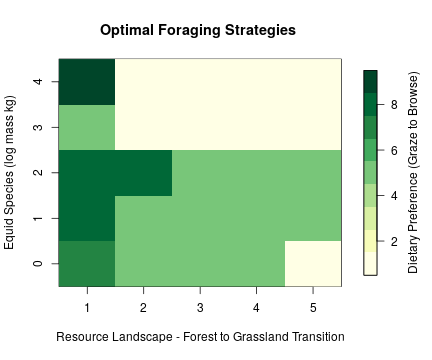

┌ Warning: RCall.jl: Loading required package: spam
│ Loading required package: dotCall64
│ Loading required package: grid
│ Spam version 2.5-1 (2019-12-12) is loaded.
│ Type 'help( Spam)' or 'demo( spam)' for a short introduction 
│ and overview of this package.
│ Help for individual functions is also obtained by adding the
│ suffix '.spam' to the function name, e.g. 'help( chol.spam)'.
│ 
│ Attaching package: ‘spam’
│ 
│ The following objects are masked from ‘package:base’:
│ 
│     backsolve, forwardsolve
│ 
│ Loading required package: maps
│ See https://github.com/NCAR/Fields for
│  an extensive vignette, other supplements and source code 
└ @ RCall /home/taran/.julia/packages/RCall/g7dhB/src/io.jl:113


RObject{NilSxp}
NULL


In [14]:
#condition_mean = condition_mean_data ./ species_list'

# Body condition mean
R"""
library(fields)
library(RColorBrewer)
pal<-brewer.pal(9,"YlGn")
leg_labels <- c("Graze 100%", "Graze 75%", "Graze 50%", "Graze 25%", "Nearest Resource",
             "Browse 25%", "Browse 50%", "Browse 75%", "Browse 100%")
leg_title <- c("Dietary Preference (Graze to Browse)")

image.plot(y=log10($(species_list_plotting)),x=c($scenario_list) , z=$(optimal_strat2), 
        main='Optimal Foraging Strategies ',
        ylab="Equid Species (log mass kg)", 
    xlab="Resource Landscape - Forest to Grassland Transition",
    legend.lab = leg_title,
    col=pal)
"""

In [38]:
using Plots

#time, data, scenarios, strats, species, configurations
p1 = body_con_data[:,8,1,1,5,1]
p2 = body_con_data[:,8,2,1,5,1]
p3 = body_con_data[:,8,3,1,5,1]
p4 = body_con_data[:,8,4,1,5,1]
p5 = body_con_data[:,8,5,1,5,1]

x1=p1[findall(x->x!=0, p1)];
x2=p2[findall(x->x!=0, p2)];
x3=p3[findall(x->x!=0, p3)];
x4=p4[findall(x->x!=0, p4)];
x5=p5[findall(x->x!=0, p5)];

p = plot(p1)
plot!(p, p2)
plot!(p3)

In [16]:
#time, data, scenarios, strats, species, configurations

using RCall
R"""
par(cex=0.6, mai=c(0.8,0.5,0.2,0.5))
par(mfrow=c(3,1)) 
 #layout(matrix(c(1,1,1), 3, 1, byrow = TRUE), heights=c(20,20,20))

plot($x,$y1, type='l', main="Mouth Content of 1kg Forager", 
    xlab="Time (s)", ylab="Forager Mouth Content (g)", 
    ylim = c(0, 10.0))#,xlim = c(6, 10))

plot($x,$y2, type='l', main="Gut Content of 1kg Forager", 
    xlab="Time (s)", ylab="Forager Gut Content (g)", 
    ylim = c(0, 2000))#,xlim = c(6, 10))

plot($x,$y3, type='l', main="Body Condition of 1kg Forager ", 
    xlab="Time (s)", ylab="Forager Body Condition (kJ)", 
    ylim = c(0, 500000))#,xlim = c(6, 10))



"""

UndefVarError: UndefVarError: y1 not defined